# Transfer Learning with Tensorflow part 2: Fine-Tuning

In [ ]:
# Check if we're using GPU
!nvidia-smi


Sat Jan 13 14:45:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Creating helper functions

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2024-01-17 17:20:41--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-17 17:20:41 (67.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
from helper_functions import *

## Load the data

In [3]:
# get 10% of training data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2024-01-17 17:20:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.118.207, 74.125.200.207, 74.125.130.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.118.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  22.4MB/s    in 8.5s    

2024-01-17 17:20:56 (18.9 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
unzip_data('10_food_classes_10_percent.zip')

In [5]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir('10_food_classes_10_percent/')

There are 2 directories and 0 images in '10_food_classes_10_percent/'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percen

In [6]:
# Create training and test directory paths
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [7]:
import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical',
                                                                            batch_size=BATCH_SIZE,
                                                                            shuffle=True)

test_data= tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                               image_size=IMG_SIZE,
                                                               label_mode='categorical',
                                                               batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[2.45571426e+02 2.55000000e+02 2.48142853e+02]
   [2.47234695e+02 2.55000000e+02 2.47545914e+02]
   [2.52127548e+02 2.54556122e+02 2.52566330e+02]
   ...
   [2.44841888e+02 1.95841888e+02 1.17270409e+02]
   [2.47714294e+02 1.99760223e+02 1.17760223e+02]
   [2.49387772e+02 2.02030624e+02 1.20030624e+02]]

  [[2.37260208e+02 2.54239807e+02 2.54857147e+02]
   [2.44571442e+02 2.54857147e+02 2.54724487e+02]
   [2.47459183e+02 2.54857147e+02 2.51489792e+02]
   ...
   [2.33046021e+02 1.83403229e+02 1.05046021e+02]
   [2.42867340e+02 1.97933701e+02 1.14933685e+02]
   [2.44928635e+02 2.03377686e+02 1.19117447e+02]]

  [[2.44005112e+02 2.51076538e+02 2.50362244e+02]
   [2.44698990e+02 2.52270416e+02 2.41127548e+02]
   [2.51744904e+02 2.54908157e+02 2.32392853e+02]
   ...
   [2.40693863e+02 1.93785736e+02 1.13739799e+02]
   [2.37142822e+02 1.95469376e+02 1.11841812e+02]
   [2.41076813e+02 2.03076813e+02 1.18505386e+02]]

  ...

  [[2.02658035e+02 2.16658035e+02 2.17658035e+02]
   [2

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=IMG_SIZE+(3,))
base_model.trainable = False

inputs=tf.keras.Input(shape=IMG_SIZE+(3,))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(10, activation='softmax')(x)
model = tf.keras.Model(inputs, output)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
model.fit(train_data_10_percent,
          epochs=5,
          validation_data=test_data,
          steps_per_epoch=len(train_data_10_percent),
          validation_steps=len(test_data))

Epoch 1/5
24/24 [==============================] - 21s 446ms/step - loss: 1.8559 - accuracy: 0.4253 - val_loss: 1.2810 - val_accuracy: 0.7496
Epoch 2/5
24/24 [==============================] - 7s 277ms/step - loss: 1.0462 - accuracy: 0.7867 - val_loss: 0.8573 - val_accuracy: 0.8196
Epoch 3/5
24/24 [==============================] - 7s 280ms/step - loss: 0.7450 - accuracy: 0.8467 - val_loss: 0.6943 - val_accuracy: 0.8444
Epoch 4/5
24/24 [==============================] - 8s 321ms/step - loss: 0.5998 - accuracy: 0.8773 - val_loss: 0.6052 - val_accuracy: 0.8588
Epoch 5/5
24/24 [==============================] - 8s 342ms/step - loss: 0.5073 - accuracy: 0.9013 - val_loss: 0.5566 - val_accuracy: 0.8620


## Model 0: Building a transfer learning model using the keras Functional API

In [ ]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2.Freeze the base model
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')

# 4. if using ResNet50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5. pass the inputs to the base_model
x = base_model(inputs)
print(f'shape after passing inputs through base model:{x.shape}')

# 6. Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f'shape after GlabalAveragePooling2D: {x.shape}')

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. compile the model
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 10. fit the model
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extration")])

shape after passing inputs through base model:(None, 7, 7, 1280)
shape after GlabalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extration/20240113-150959
Epoch 1/5
24/24 [==============================] - 12s 231ms/step - loss: 1.9029 - accuracy: 0.4147 - val_loss: 1.3155 - val_accuracy: 0.7056
Epoch 2/5
24/24 [==============================] - 4s 174ms/step - loss: 1.0983 - accuracy: 0.7707 - val_loss: 0.8715 - val_accuracy: 0.8240
Epoch 3/5
24/24 [==============================] - 7s 286ms/step - loss: 0.7861 - accuracy: 0.8347 - val_loss: 0.7140 - val_accuracy: 0.8339
Epoch 4/5
24/24 [==============================] - 3s 126ms/step - loss: 0.6379 - accuracy: 0.8560 - val_loss: 0.6192 - val_accuracy: 0.8569
Epoch 5/5
24/24 [==============================] - 4s 172ms/step - loss: 0.5498 - accuracy: 0.8760 - val_loss: 0.5447 - val_accuracy: 0.8750


In [ ]:
 # Evaluate on the full test dataset
 model_0.evaluate(test_data)

79/79 [==============================] - 7s 77ms/step - loss: 0.5589 - accuracy: 0.8616


[0.5589056611061096, 0.8615999817848206]

In [ ]:
# Check the layer in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_5
1 rescaling_6
2 normalization_3
3 rescaling_7
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [ ]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_6 (Rescaling)     (None, None, None, 3)        0         ['input_5[0][0]']             
                                                                                                  
 normalization_3 (Normaliza  (None, None, None, 3)        7         ['rescaling_6[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_7 (Rescaling)     (None, None, None, 3)        0         ['normalization_3

In [ ]:
model_0.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
________________

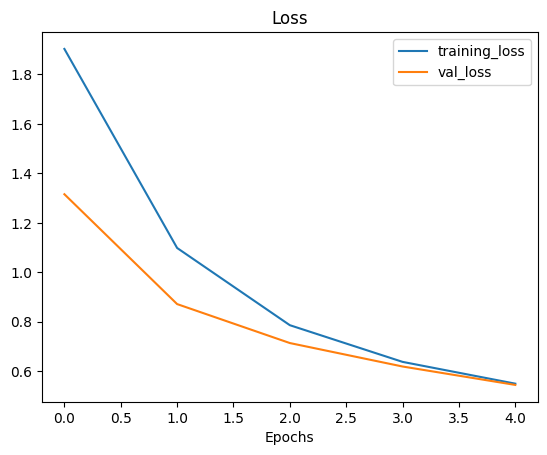

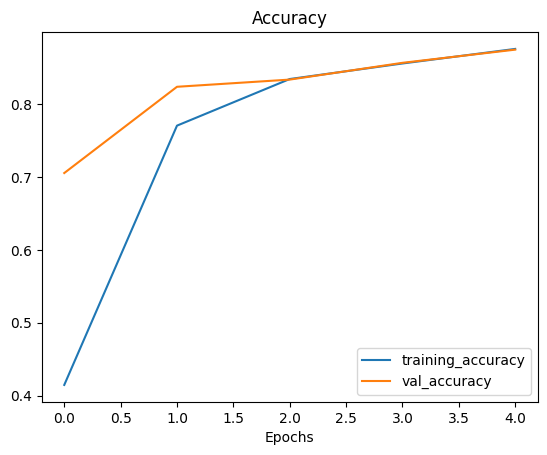

In [ ]:
# our model training curves
plot_loss_curves(history_0)

## Getting a feature vector from trained model

In [ ]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f'Random input_tensor:{input_tensor}')

# Pass the random tensor through the global average pooling 2d layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'2d global average pooled random tensor:\n {global_average_pooled_tensor}\n')

# Check the shape of the different tensors
print(f'shape of input tensor:{input_tensor.shape}')
print(f'shape of global average:{global_average_pooled_tensor.shape}')

Random input_tensor:[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]
2d global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

shape of input tensor:(1, 4, 4, 3)
shape of global average:(1, 3)


In [ ]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [ ]:
tf.reduce_mean(input_tensor[0, :, :, 0]), tf.reduce_mean(input_tensor[0, :, :, 1]), tf.reduce_mean(input_tensor[0, :, :, 2])

(<tf.Tensor: shape=(), dtype=float32, numpy=-0.09368647>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.45840448>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.2885598>)

In [ ]:
global_max_pool_layer = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
global_max_pool_layer

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

## Running a series of transfer learning experiments

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2024-01-16 14:59:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.18.207, 142.250.153.207, 142.250.145.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.18.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  38.4MB/s    in 3.7s    

2024-01-16 14:59:23 (34.8 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
unzip_data('10_food_classes_1_percent.zip')

In [ ]:
walk_through_dir('10_food_classes_1_percent/')

There are 2 directories and 0 images in '10_food_classes_1_percent/'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There 

In [ ]:
train_dir = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                           label_mode='categorical',
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224,224,3), name='input_layer')

x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
model_1_percent = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
model_1_percent.compile(loss='categorical_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=['accuracy'])

history_1_percent = model_1_percent.fit(train_data_1_percent,
                                        epochs=5,
                                        steps_per_epoch=len(train_data_1_percent),
                                        validation_data=test_data,
                                        validation_steps=int(0.25 * len(test_data)))

Epoch 1/5
3/3 [==============================] - 11s 2s/step - loss: 2.2592 - accuracy: 0.1571 - val_loss: 2.1143 - val_accuracy: 0.2484
Epoch 2/5
3/3 [==============================] - 2s 811ms/step - loss: 1.9565 - accuracy: 0.4000 - val_loss: 1.9767 - val_accuracy: 0.3536
Epoch 3/5
3/3 [==============================] - 2s 1s/step - loss: 1.7295 - accuracy: 0.7000 - val_loss: 1.8366 - val_accuracy: 0.4539
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.4933 - accuracy: 0.8143 - val_loss: 1.7311 - val_accuracy: 0.5082
Epoch 5/5
3/3 [==============================] - 2s 828ms/step - loss: 1.3520 - accuracy: 0.8714 - val_loss: 1.6302 - val_accuracy: 0.5477


## Adding data augmentation right into the model


In [ ]:
import tensorflow as tf

# Create data augmentation state with horizontal flipping, rotatins, zooms, etc..
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2)
], name='data_augmentation')

### Visualize our data augmentation layer

(-0.5, 485.5, 440.5, -0.5)

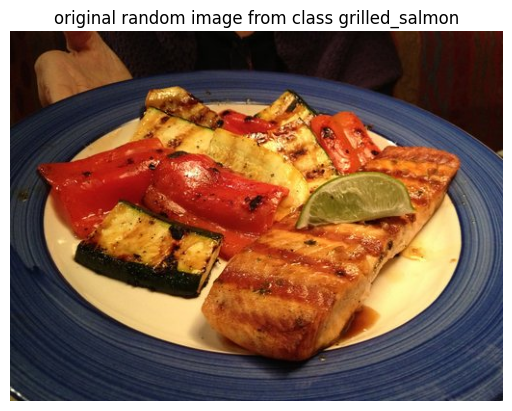

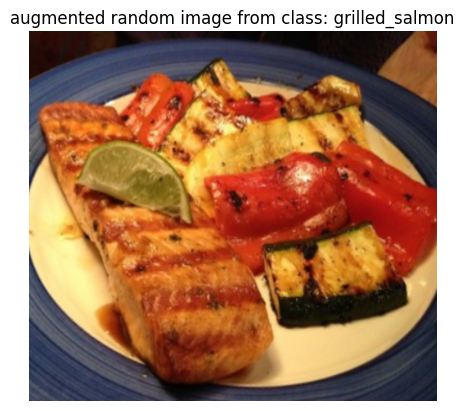

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read and plot
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f'original random image from class {target_class}')
plt.axis(False)

# Plot augmented random image
augmented_img = data_augmentation(img, training=True) / 255.
plt.figure()
plt.imshow(augmented_img)
plt.title(f'augmented random image from class: {target_class}')
plt.axis(False)

## Model 1: Feature extration tranfer learning on 1$ of the data with data augmentation

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation as a layer
x = data_augmentation(inputs)

x = base_model(x, training=False)

# Pool output features of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

# Put a dense layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

model_1 = tf.keras.Model(inputs, outputs)

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, 3)           0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810 

In [ ]:
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                       experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20240116-152504
Epoch 1/5
3/3 [==============================] - 19s 3s/step - loss: 2.3745 - accuracy: 0.0571 - val_loss: 2.2730 - val_accuracy: 0.1908
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.1342 - accuracy: 0.2000 - val_loss: 2.1540 - val_accuracy: 0.2467
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9301 - accuracy: 0.4000 - val_loss: 2.0460 - val_accuracy: 0.3141
Epoch 4/5
3/3 [==============================] - 7s 3s/step - loss: 1.7866 - accuracy: 0.5714 - val_loss: 1.9531 - val_accuracy: 0.3602
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.5784 - accuracy: 0.7000 - val_loss: 1.8490 - val_accuracy: 0.4260


In [ ]:
# Evalute on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)

79/79 [==============================] - 6s 69ms/step - loss: 1.8308 - accuracy: 0.4428


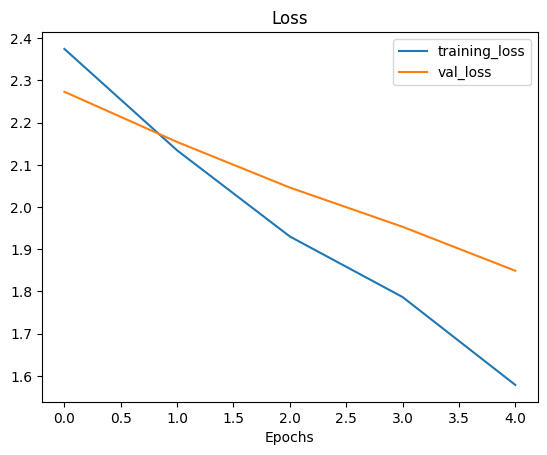

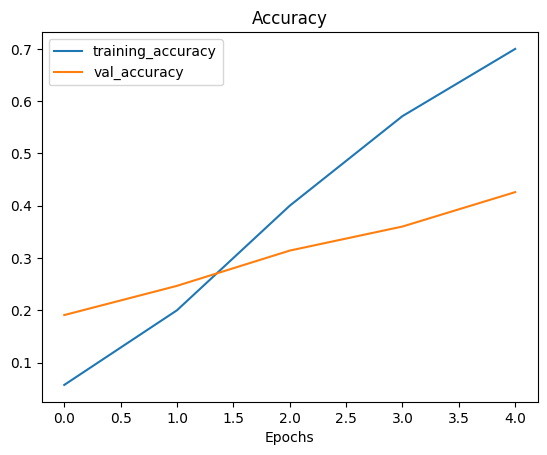

In [ ]:
# Plot loss curves
plot_loss_curves(history_1_percent)

## Model 2: feature extraction transfer learning model with 10% of data and data augmentation

In [8]:
import tensorflow as tf

data_augmented = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2)
])

In [17]:
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
inputs = tf.keras.layers.Input(shape=input_shape, name='input_layer')
x = data_augmented(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pool_layer')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)
model_2 = tf.keras.Model(inputs, outputs)
model_2.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pool_layer   (None, 1280)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (5

In [18]:
 model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])


### Creating a Modelcheckpoint callback

In [19]:
# checkpoint path
checkpoint_path = "ten_percent_model_checkpoints/checkpoint.ckpt"

# Create a ModelCheckpoint callback thata saves the model's weights
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq='epoch',
                                                         verbose=1)

In [20]:
initial_epochs = 5
history_model_2 = model_2.fit(train_data_10_percent,
                              epochs=initial_epochs,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data,
                              validation_steps=int(0.25 * len(test_data)),
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="10_percent_data_aug"),
                                         checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240117-174103
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9717 - accuracy: 0.3200
Epoch 1: saving model to ten_percent_model_checkpoints/checkpoint.ckpt
24/24 [==============================] - 37s 1s/step - loss: 1.9717 - accuracy: 0.3200 - val_loss: 1.4071 - val_accuracy: 0.7039
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2995 - accuracy: 0.6947
Epoch 2: saving model to ten_percent_model_checkpoints/checkpoint.ckpt
24/24 [==============================] - 20s 782ms/step - loss: 1.2995 - accuracy: 0.6947 - val_loss: 0.9531 - val_accuracy: 0.8059
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9883 - accuracy: 0.7773
Epoch 3: saving model to ten_percent_model_checkpoints/checkpoint.ckpt
24/24 [==============================] - 21s 867ms/step - loss: 0.9883 - accuracy: 0.7773 - val_loss: 0.7670 - val_accuracy: 0.8322
Epoch 4/5
24/24 [===========

In [21]:
# evaluate model_2
result_model_2 = model_2.evaluate(test_data)

79/79 [==============================] - 8s 93ms/step - loss: 0.6146 - accuracy: 0.8476


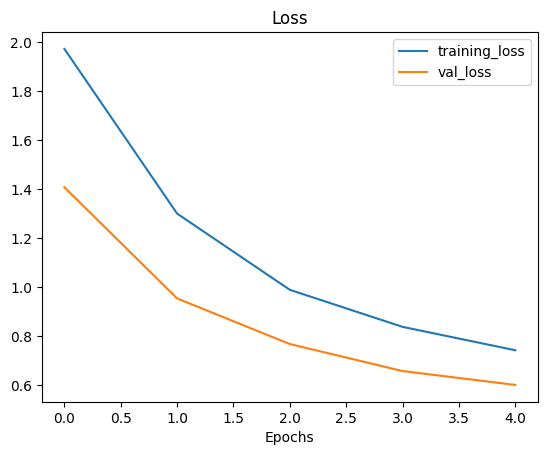

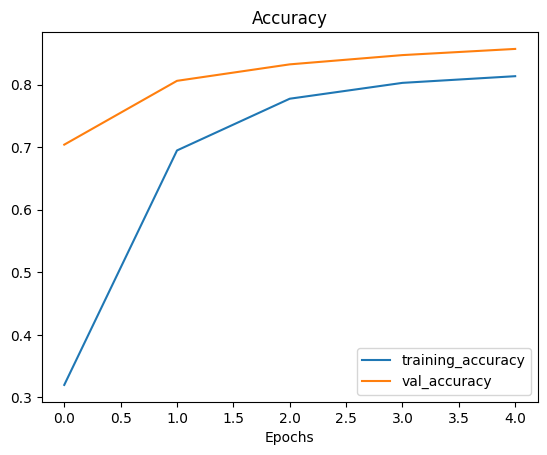

In [22]:
plot_loss_curves(history_model_2)

### Loading in checkpointed weights


In [23]:
# Load in saved model
model_2.load_weights(checkpoint_path)

In [24]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 7s 83ms/step - loss: 0.6146 - accuracy: 0.8476


In [25]:
result_model_2 == loaded_weights_model_results

False

In [26]:
result_model_2, loaded_weights_model_results

([0.6145669221878052, 0.847599983215332],
 [0.6145671010017395, 0.847599983215332])

In [27]:
# check to see if loaded model results are ver close
import numpy as np
np.isclose(np.array(result_model_2), np.array(loaded_weights_model_results))

array([ True,  True])

In [28]:
# Check the difference between the two results
print(np.array(result_model_2) - np.array(loaded_weights_model_results))

[-1.78813934e-07  0.00000000e+00]
